<a href="https://colab.research.google.com/github/adasamonte/CNN-Segmentation-Model-Lungs/blob/main/SegmentationModel_CLAHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

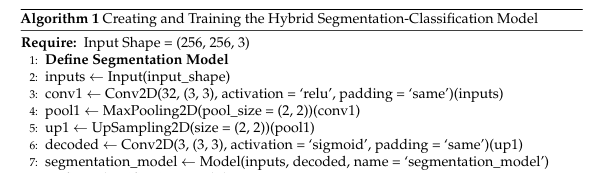

#SEGMENTATION MODEL - SEGMENTING THE LUNGS

- for isolating the lungs to generate heatmaps within the lung region (Gradcam)

- Preprocessed is for the lungs to have the same contrast, less noise even when using different datasets

- datasets used are Shenzen, Radiography Chest Radio

- preprocess is to reduce noise, contrast, etc...



# preprocess file names
- Dataset tb Radio - Tuberculosis-x.png and Normal-x.png
- Dataset Shenzen - CHNCXR_xxxx_1.png and CHNCXR_xxxx_0.png
- Dataset Shenzen Mask - CHNCXR_xxxx_1_mask.png and CHNCXR_xxxx_0_mask.png

In [ ]:
#Mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Preprocessed dataset (CLAHE) paths - TESTED
# tb_dir = "/content/drive/MyDrive/preprocessed/TB/CLAHE"
# normal_dir = "/content/drive/MyDrive/preprocessed/NORMAL/CLAHE"


# #Preprocessed Dataset (BCET PATHS)
# tb_dir = "/content/drive/MyDrive/preprocessed/TB/BCET"
# normal_dir = "/content/drive/MyDrive/preprocessed/NORMAL/BCET"

#
tb_dir = "/content/drive/MyDrive/preprocessed/preprocessed/TB/CLAHE"
normal_dir = "/content/drive/MyDrive/preprocessed/preprocessed/NORMAL/CLAHE"


# Mask folder
mask_dir = "/content/drive/MyDrive/DatasetFiles/DatasetFiles/mask"

# Gather all preprocessed images (TB + Normal)
img_files = [os.path.join(tb_dir, f) for f in os.listdir(tb_dir) if f.endswith(".png")] + \
            [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.endswith(".png")]

print("Total preprocessed images found:", len(img_files))
print("Masks are in:", mask_dir)


Total preprocessed images found: 4862
Masks are in: /content/drive/MyDrive/DatasetFiles/DatasetFiles/mask


In [ ]:
# Build set of mask base names (strip "_mask.png")
masks = set([f.replace("_mask.png", "") for f in os.listdir(mask_dir)])

# Keep only images that have a matching mask
valid_files = [f for f in img_files if os.path.splitext(os.path.basename(f))[0] in masks]

print("Valid image–mask pairs:", len(valid_files))
print("Removed due to missing mask:", len(img_files) - len(valid_files))


Valid image–mask pairs: 566
Removed due to missing mask: 4296


In [ ]:
import tensorflow as tf

IMG_SIZE = (256, 256)

def load_image_and_mask(img_path):
    # Extract base filename (e.g. CHNCXR_xxxx_0)
    filename = tf.strings.split(img_path, os.sep)[-1]
    base = tf.strings.regex_replace(filename, ".png", "")
    mask_filename = tf.strings.join([base, "_mask.png"])
    mask_path = tf.strings.join([mask_dir, "/", mask_filename])

    # Load CXR image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE)
    mask = tf.cast(mask > 0, tf.float32)

    return img, mask

def tf_dataset(filelist, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices(filelist)
    dataset = dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch).prefetch(tf.data.AUTOTUNE)
    return dataset


In [ ]:
# Shuffle first (to mix TB and Normal before splitting)
import random
random.shuffle(valid_files)

# 80/20 split
train_size = int(0.8 * len(valid_files))
train_files = valid_files[:train_size]
val_files = valid_files[train_size:]

train_ds = tf_dataset(train_files)
val_ds = tf_dataset(val_files)

print("Training samples:", len(train_files))
print("Validation samples:", len(val_files))


Training samples: 452
Validation samples: 114


In [ ]:
#Data Augmentation

# After defining load_image_and_mask()

def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)

    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    return img, mask

def tf_dataset(filelist, batch=8, augment_data=False):
    dataset = tf.data.Dataset.from_tensor_slices(filelist)
    dataset = dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch).prefetch(tf.data.AUTOTUNE)
    return dataset

# Replace your old dataset creation with this:
train_ds = tf_dataset(train_files, augment_data=True)
val_ds   = tf_dataset(val_files, augment_data=False)


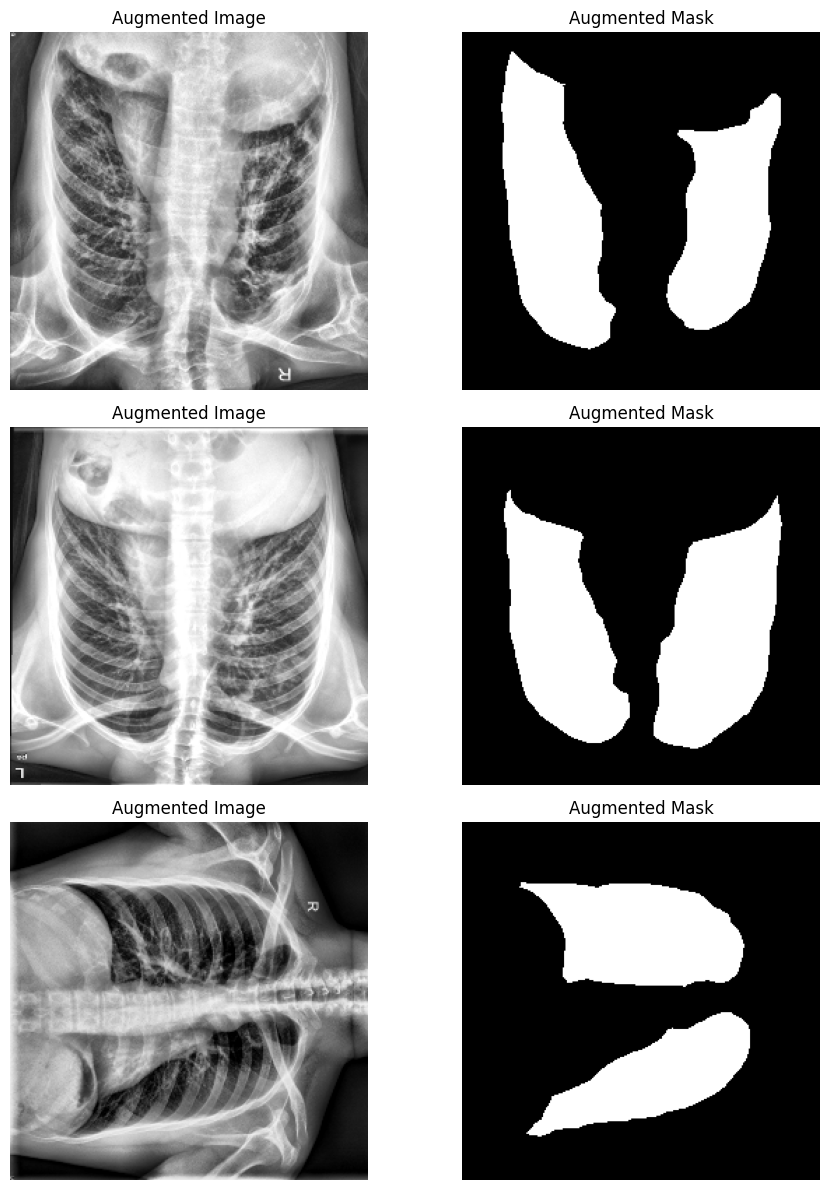

In [ ]:
# Visualize some augmented samples
import matplotlib.pyplot as plt

# Take 1 batch from the augmented training set
sample_img, sample_mask = next(iter(train_ds))

num_examples = 3  # number of samples to display
plt.figure(figsize=(10, num_examples * 4))

for i in range(num_examples):
    plt.subplot(num_examples, 2, 2*i + 1)
    plt.imshow(sample_img[i])
    plt.title("Augmented Image")
    plt.axis("off")

    plt.subplot(num_examples, 2, 2*i + 2)
    plt.imshow(sample_mask[i][:,:,0], cmap="gray")
    plt.title("Augmented Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


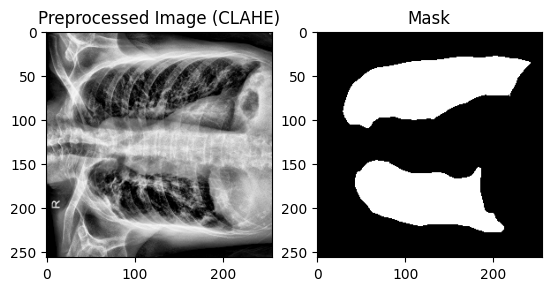

In [ ]:
import matplotlib.pyplot as plt

# Show one random example
sample_img, sample_mask = next(iter(train_ds))

# plt.subplot(1,2,1); plt.imshow(sample_img[0]); plt.title("Preprocessed Image (CLAHE)")

plt.subplot(1,2,1); plt.imshow(sample_img[0]); plt.title("Preprocessed Image (CLAHE)")
plt.subplot(1,2,2); plt.imshow(sample_mask[0][:,:,0], cmap="gray"); plt.title("Mask")
plt.show()


In [ ]:
from tensorflow.keras import layers, Model, Input

def unet_model(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape, name="base_input")

    # Encoder
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, 3, activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(256, 3, activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    b = layers.Conv2D(512, 3, activation="relu", padding="same")(p4)
    b = layers.Conv2D(512, 3, activation="relu", padding="same")(b)

    # Decoder
    u4 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(b)
    concat4 = layers.Concatenate()([u4, c4])
    c5 = layers.Conv2D(256, 3, activation="relu", padding="same")(concat4)
    c5 = layers.Conv2D(256, 3, activation="relu", padding="same")(c5)

    u3 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    concat3 = layers.Concatenate()([u3, c3])
    c6 = layers.Conv2D(128, 3, activation="relu", padding="same")(concat3)
    c6 = layers.Conv2D(128, 3, activation="relu", padding="same")(c6)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    concat2 = layers.Concatenate()([u2, c2])
    c7 = layers.Conv2D(64, 3, activation="relu", padding="same")(concat2)
    c7 = layers.Conv2D(64, 3, activation="relu", padding="same")(c7)

    u1 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c7)
    concat1 = layers.Concatenate()([u1, c1])
    c8 = layers.Conv2D(32, 3, activation="relu", padding="same")(concat1)
    c8 = layers.Conv2D(32, 3, activation="relu", padding="same")(c8)

    # Output
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c8)

    return Model(inputs, outputs)

seg_model = unet_model()
seg_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ base_input          │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │        896 │ base_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_22[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_24[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_26[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_28[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_30[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │    524,544 │ conv2d_31[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 7,760,097 (29.60 MB)

 Trainable params: 7,760,097 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
seg_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = seg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.7111 - loss: 0.5748 - val_accuracy: 0.7477 - val_loss: 0.5029
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 340ms/step - accuracy: 0.7496 - loss: 0.5067 - val_accuracy: 0.7477 - val_loss: 0.4555
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step - accuracy: 0.7567 - loss: 0.4571 - val_accuracy: 0.8331 - val_loss: 0.3624
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 302ms/step - accuracy: 0.8589 - loss: 0.3549 - val_accuracy: 0.8944 - val_loss: 0.2679
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 345ms/step - accuracy: 0.9168 - loss: 0.2204 - val_accuracy: 0.9274 - val_loss: 0.1953
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 342ms/step - accuracy: 0.9359 - loss: 0.1647 - val_accuracy: 0.9518 - val_loss: 0.1263
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 339ms/step - accuracy: 0.9490 - loss: 0.1280 - val_accuracy: 0.9663 - val_loss: 0.0901
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - accuracy: 0.9612 - loss: 0.1031 - val_accura

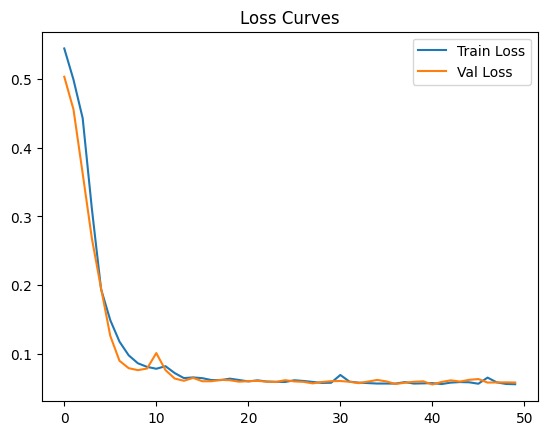

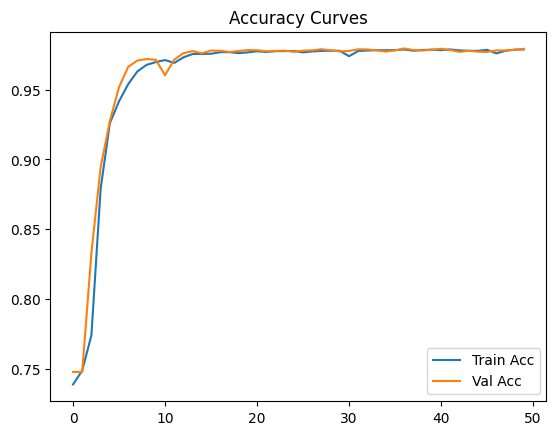

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend(); plt.title("Loss Curves"); plt.show()

plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend(); plt.title("Accuracy Curves"); plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


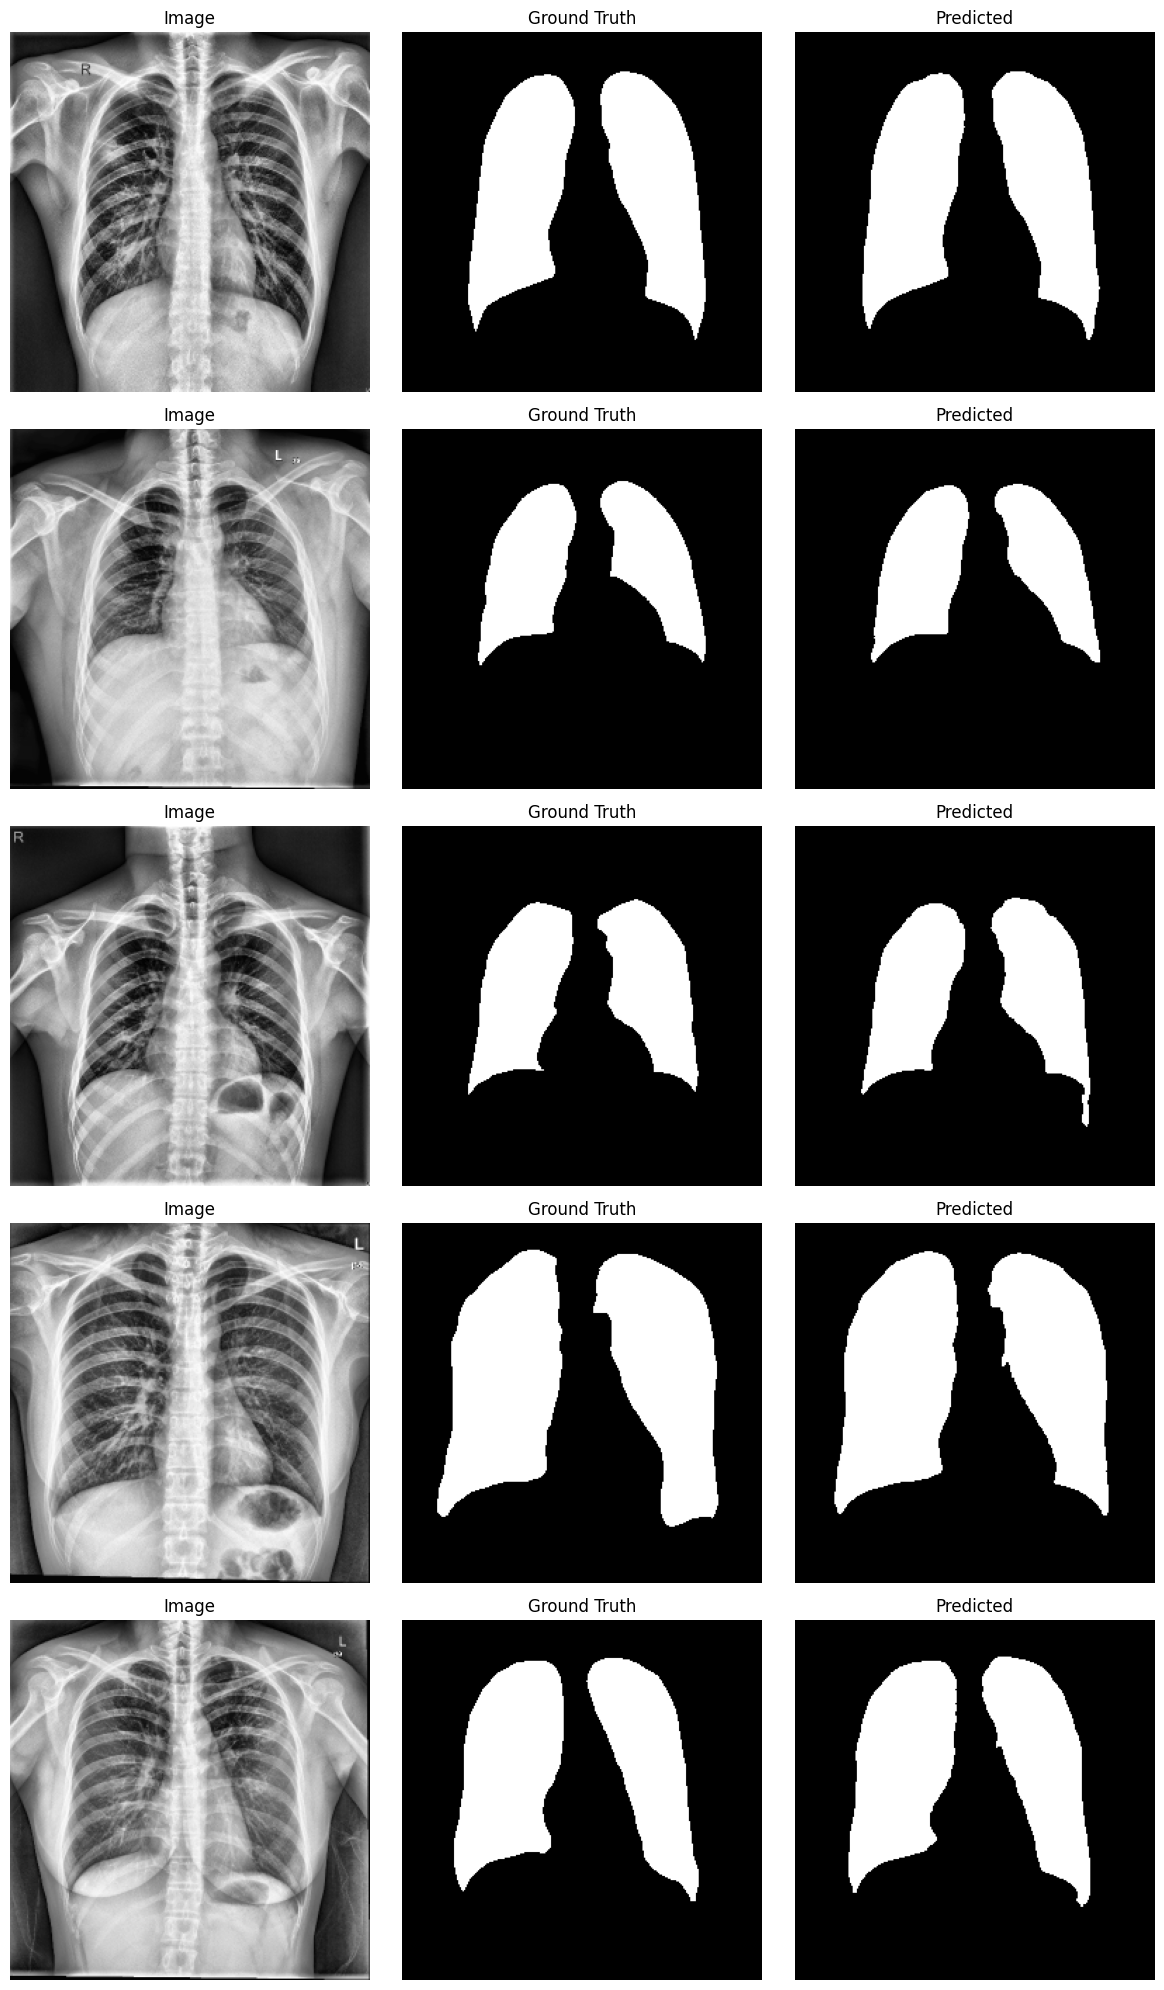

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

test_img, test_mask = next(iter(val_ds))
pred_mask = seg_model.predict(test_img)

num_examples = 5  # number of samples to display
plt.figure(figsize=(12, num_examples * 4))

for i in range(num_examples):
    # Image
    plt.subplot(num_examples, 3, 3*i + 1)
    plt.imshow(test_img[i])
    plt.title("Image")
    plt.axis("off")

    # Ground Truth
    plt.subplot(num_examples, 3, 3*i + 2)
    plt.imshow(test_mask[i][:,:,0], cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    # Predicted
    plt.subplot(num_examples, 3, 3*i + 3)
    plt.imshow(pred_mask[i][:,:,0] > 0.5, cmap="gray")
    plt.title("Predicted")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Define metrics first
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Define dice loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Compile model with hybrid loss + metrics
seg_model.compile(
    optimizer="adam",
    loss=lambda y_true, y_pred: 0.5*tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred),
    metrics=[dice_coef, iou_coef]
)

# Train
history = seg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 319ms/step - dice_coef: 0.9360 - iou_coef: 0.8800 - loss: 0.0665 - val_dice_coef: 0.9362 - val_iou_coef: 0.8802 - val_loss: 0.0733
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 279ms/step - dice_coef: 0.9446 - iou_coef: 0.8952 - loss: 0.0585 - val_dice_coef: 0.9403 - val_iou_coef: 0.8874 - val_loss: 0.0670
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 298ms/step - dice_coef: 0.9463 - iou_coef: 0.8983 - loss: 0.0565 - val_dice_coef: 0.9392 - val_iou_coef: 0.8855 - val_loss: 0.0701
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - dice_coef: 0.9468 - iou_coef: 0.8991 - loss: 0.0563 - val_dice_coef: 0.9405 - val_iou_coef: 0.8879 - val_loss: 0.0689
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 325ms/step - dice_coef: 0.9474 - iou_coef: 0.9001 - loss: 0.0557 - val_dice_coef: 0.9426 - val_iou_coef: 0.8916 - val_loss: 0.0659
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 284ms/step - dice_coef: 0.9478 - iou_coef: 0.9009 - loss: 0.0553 - val_dice_coef: 0.9444 - va

In [ ]:
#Save the model


# seg_model.save("/content/drive/MyDrive/lung_segmentation_model_CLAHE.h5")

# seg_model.save("/content/drive/MyDrive/lung_segmentation_model_BCET.h5")

seg_model.save("/content/drive/MyDrive/lung_segmentation_model_CLAHE_2.h5")
